In [34]:
import os

# os.environ["MODIN_ENGINE"] = "ray"
from datetime import datetime, timedelta, timezone
from itertools import cycle, islice

# import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
from sqlalchemy.orm import Session
from sqlalchemy import select

from utils.db_utils import DB_ENGINE, Category, Restaurant, Item

In [35]:
with Session(DB_ENGINE) as session:
    query = select(Category)
    category_df = pd.read_sql_query(query, session.bind)
    query = select(Restaurant)
    restaurant_df = pd.read_sql_query(query, session.bind)
    query = select(Item)
    # session.query(Item).delete()
    item_df = pd.read_sql_query(query, session.bind)
    # cur = db_con.execute("SELECT * FROM items")
    # results = cur.fetchall()
    # UTC is 8 hours ahead of PT
    # pt_now = datetime.now(timezone.utc) - timedelta(hours=8)
    # db_df.to_csv(f"items_{pt_now.isoformat()}.csv")


In [36]:
category_df

,id,name,rel_url
0,1,24 Hours Food,/category/emeryville-ca/24-hours
1,2,Acai food,/category/emeryville-ca/acai
2,3,Afghan Food,/category/emeryville-ca/afghan
3,4,African Food,/category/emeryville-ca/african
4,5,Alcohol,/category/emeryville-ca/alcohol
...,...,...,...
963,964,Wine,/category/oakland-ca/wine
964,965,Wings,/category/oakland-ca/wings
965,966,Wraps,/category/oakland-ca/wrap
966,967,Japanese BBQ,/category/oakland-ca/yakiniku


In [37]:
category_df['name'].nunique()

196

In [38]:
restaurant_df

,id,name,rating,rel_url,category_id,vegetarian_friendly_score
0,1,Acai Aura (2353 E 12th St),2.8,/store/acai-aura-2353-e-12th-st/0K9ccjlkQCC9H4...,2,NaN
1,2,Gunpowder Cafe (2353 E 12th St Kitchen),0.0,/store/gunpowder-cafe-2353-e-12th-st-kitchen/p...,2,NaN
2,3,The Vegan Breakfast,0.0,/store/the-vegan-breakfast/6X67tuc5Tg-lCm53Ev9SLA,2,NaN
3,4,Marina Supermarket,0.0,/store/marina-supermarket/zhWQdjpvVseZsSkURyDAXA,2,NaN
4,5,Jay Vee Liquors,4.8,/store/jay-vee-liquors/GzwW2nC8TCSA4LulH9insA,2,NaN
...,...,...,...,...,...,...
519,520,"Yi Fang Taiwan Fruit Tea, Colma",4.9,/store/yi-fang-taiwan-fruit-tea-colma/0CdB9Sgq...,369,NaN
520,521,Flaming Kitchen,0.0,/store/flaming-kitchen/8-d3mOH8RwijZU2ztOLYoQ,369,NaN
521,522,Happy Lemon(Camino Tassajara),0.0,/store/happy-lemoncamino-tassajara/ES1GExLtULK...,369,NaN
522,523,CVS (175 41St Street),4.7,/store/cvs-175-41st-street/C5en1NiJVYmuNV7CJP3kgA,912,NaN


In [39]:

item_df

,id,name,description,rel_url,restaurant_id,vegetarian_friendly_score
0,1,Cheese Quesadilla,"Flour tortillas, mixed cheeses, black olives, ...","Cheese QuesadillaFlour tortillas, mixed cheese...",257,None
1,2,Kale Caesar Salad,"Kale lettuce, croutons, parmesan cheese, caesa...","Kale Caesar SaladKale lettuce, croutons, parme...",257,None
2,3,Chicken Cobb Salad,"Chopped greens, tomato, crisp bacon, hardboile...","Chicken Cobb SaladChopped greens, tomato, cris...",257,None
3,4,BBQ Chicken Salad,"Mix green lettuce, red onions, tomatoes, mix c...","BBQ Chicken SaladMix green lettuce, red onions...",257,None
4,5,Mediterranean Chicken Salad,"Romaine lettuce, feta cheese, black olives, to...","Mediterranean Chicken SaladRomaine lettuce, fe...",257,None
...,...,...,...,...,...,...
2029,2030,Honey Mango 100% Real Fruit - 10 paletas,"100% Real Mangos, Sweetened With Agave Honey ...",Honey Mango 100% Real Fruit - 10 paletas+81,81,None
2030,2031,Strawberries and Cream - 5 Paletas,"100% Strawberry, heavy cream and milk. 5 Pale...",Strawberries and Cream - 5 Paletas+81,81,None
2031,2032,Honey Strawberries (Vegan) - 10 Paletas,"100% Fresh Strawberry's, Sweetened With Agave ...",Honey Strawberries (Vegan) - 10 Paletas+81,81,None
2032,2033,Honey Mango 100% Real Fruit - 5 paletas,Honey Mango 100% Real Fruit,Honey Mango 100% Real Fruit - 5 paletas+81,81,None


In [40]:
def extract_city_from_category_url(row):
    # ex category_rel_url: /category/emeryville-ca/african
    return row["rel_url"].split("/", 3)[2].rsplit("-", 1)[0].title()


category_df["city"] = category_df.apply(lambda row: extract_city_from_category_url(row), axis=1)
category_df.head()

,id,name,rel_url,city
0,1,24 Hours Food,/category/emeryville-ca/24-hours,Emeryville
1,2,Acai food,/category/emeryville-ca/acai,Emeryville
2,3,Afghan Food,/category/emeryville-ca/afghan,Emeryville
3,4,African Food,/category/emeryville-ca/african,Emeryville
4,5,Alcohol,/category/emeryville-ca/alcohol,Emeryville


In [41]:
category_df.groupby(["city"]).size()

city
Alameda       193
Albany        195
Berkeley      193
Emeryville    193
Oakland       194
dtype: int64

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


/home/dhanush/.pyenv/versions/3.10.0/envs/py310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


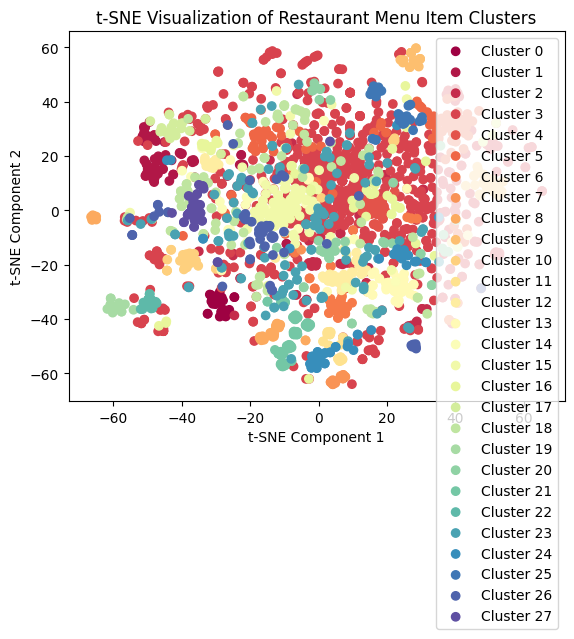

In [42]:
%time

# Assuming your DataFrame is called item_df
# Combining name and description columns
item_df['combined_text'] = item_df['name'] + ' ' + item_df['description']

# Vectorizing the text
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(item_df['combined_text'])

# Clustering with k-means
n_clusters = 31
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
item_df['centroid_id'] = kmeans.fit_predict(X)

# Applying t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

# Visualizing the results with matplotlib
unique_labels = np.unique(item_df['centroid_id'])
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for centroid_id, color in zip(unique_labels, colors):
    cluster_indices = item_df[item_df['centroid_id'] == centroid_id].index
    plt.scatter(X_tsne[cluster_indices, 0], X_tsne[cluster_indices, 1], c=[color]*len(cluster_indices), label=f"Cluster {centroid_id}")

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.title('t-SNE Visualization of Restaurant Menu Item Clusters')
plt.show()

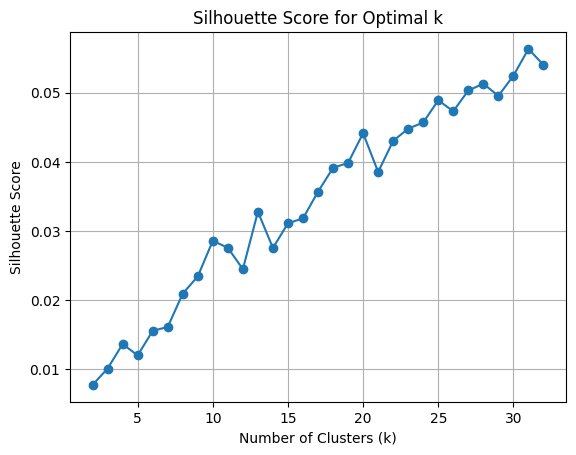

In [43]:
silhouette_scores = []

# Trying different values of k (number of clusters)
k_values = range(2, n_clusters+5)  # Silhouette score is not defined for k=1

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)  # Add the n_init and random_state parameters explicitly
    labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, labels))

plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.grid(True)
plt.show()

In [44]:
for cluster_id in range(n_clusters):
    cluster_items = item_df[item_df['centroid_id'] == cluster_id][['name', 'description']]
    print(f"Cluster {cluster_id}: # of items = {len(cluster_items)}")
    for _, row in cluster_items.head(5).iterrows():
        print(f"{row['name']}: {row['description']}\n")

Cluster 0: # of items = 34
Chow Fun with Seafood: 

H.K Style Beef Chow Fun: 

Chow Fun with Spareribs in Black Bean Sauce: 

Chow Mein with Bean Sprout &amp; Soy Sauce: 

Singapore Style Chow Fun: 

Cluster 1: # of items = 69
Honey Cilantro Chicken: Magoo’s honey cilantro sauce with steamed rice, sauteed veggies, sour cream, and killer salsa.

Shrimp Tacos: 2 tacos, fresh salsa, sriracha aioli, spicy salsa on side, guacamole, and chips

Single Egg: 

Sisig Burrito: Tortilla-wrapped chicken or pork sisig, pickled vegetable, fries, melted nacho cheese, sriracha mayo, sour cream, salsa verde, and cilantro. Try our bestselling signature sisig-based entrées.

Sisig Fries O.G.: Straight-cut fries with chicken or pork sisig topped with jalapeños, sriracha mayo, salsa verde, sour cream, green, and white onions, and garnished with bread crumbs and chili powder. Try our bestselling signature sisig based entrées.

Cluster 2: # of items = 64
Beef and Lamb Mix Plate: Delicious grilled beef and lam